In [1]:
# Code to train PRISSMM NLP models
# execution on DFCI data is not currently possible as they contain protected health information.
# code is provided for demonstration and research purposes. it is not intended or optimized for production use.

In [ ]:
import pandas as pd
import numpy as np

In [5]:
# Load labeled data. Each observation represents one imaging report.
# Relevant columns for gold standard labeled data: any_cancer, adrenal, bone, brain, liver, lung, nodes, peritoneum, pleura, response, progression.
# We did not train models to identify disease in lung or pleura (local disease sites for lung cancer) in this analysis.
with open('manual_label_analysis.csv') as f:
  label_analysis = pd.read_csv(f)
  

label_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17958 entries, 0 to 17957
Data columns (total 24 columns):
Unnamed: 0           17958 non-null int64
patient_id             17958 non-null int64
ehr_scan_date        17958 non-null object
PROC_DESCR           17958 non-null object
NARR_TXT             17958 non-null object
IMPRESS_TXT          17958 non-null object
os_date              17710 non-null object
died                 17958 non-null object
scan_to_os_date      17710 non-null float64
survived_6_months    17958 non-null int64
scan_type            17958 non-null float64
auto_type            17958 non-null float64
any_cancer           17958 non-null int64
redcap_resp_prog     11650 non-null float64
adrenal              17958 non-null int64
bone                 17958 non-null int64
brain                17958 non-null int64
liver                17958 non-null int64
lung                 17958 non-null int64
nodes                17958 non-null int64
peritoneum           17958 non-null

In [6]:
# parse text for input into models
# combine NARR_TXT and IMPRESS_TXT (narrative and impression fields of imaging reports) and get rid of carriage returns
label_analysis = label_analysis.assign(imaging_text=label_analysis.NARR_TXT + ' ' + label_analysis.IMPRESS_TXT)
label_analysis['imaging_text'] = label_analysis.imaging_text.str.replace(r'\r\n', ' ')

print(label_analysis.info())

# drop duplicate reports; the most common reason for this was a CT chest/abdomen/pelvis with identical interpretations entered for the chest and the abdomen/pelvis
label_analysis = label_analysis.drop_duplicates(subset='imaging_text')
print(label_analysis.info())
print()

# drop 'reports' of outside scans, which just indicate that a scan was performed but do not contain useful text
label_analysis = label_analysis[label_analysis['imaging_text'].str.contains("it has been imported") == False]
print(label_analysis.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17958 entries, 0 to 17957
Data columns (total 25 columns):
Unnamed: 0           17958 non-null int64
patient_id             17958 non-null int64
ehr_scan_date        17958 non-null object
PROC_DESCR           17958 non-null object
NARR_TXT             17958 non-null object
IMPRESS_TXT          17958 non-null object
os_date              17710 non-null object
died                 17958 non-null object
scan_to_os_date      17710 non-null float64
survived_6_months    17958 non-null int64
scan_type            17958 non-null float64
auto_type            17958 non-null float64
any_cancer           17958 non-null int64
redcap_resp_prog     11650 non-null float64
adrenal              17958 non-null int64
bone                 17958 non-null int64
brain                17958 non-null int64
liver                17958 non-null int64
lung                 17958 non-null int64
nodes                17958 non-null int64
peritoneum           17958 non-null

In [7]:
import keras
from keras.preprocessing.text import Tokenizer


Using TensorFlow backend.


In [8]:
# get training and validation patients

with open('training_ids.csv') as f:
  training_ids = pd.read_csv(f)

with open('validation_ids.csv') as f:
  validation_ids = pd.read_csv(f)



In [9]:
# find maximum length of imaging report in words (which was 918); set maximum length for model training to slightly more than this
counts = label_analysis['imaging_text'].str.split().apply(len)
print(counts.max())
maxlen=1000

918


In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, concatenate
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D




In [11]:
# helper function to plot confusion matrix
# based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    import numpy as np


    from sklearn.metrics import confusion_matrix
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(False)
    plt.show()

In [12]:
# basic starting architecture for models originally was based on (copied from) Keras IMDB sentiment example at
# https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py


def get_target_model(target):
  # set parameters:
  import matplotlib.pyplot as plt
  import matplotlib as mpl
  from keras.preprocessing import sequence
  from keras.models import Sequential, Model
  from keras.layers import Input, Dense, Dropout, Activation, concatenate
  from keras.layers import Embedding
  from keras.layers import Conv1D, GlobalMaxPooling1D
  
  max_features = 20000
  maxlen = 1000
  batch_size = 32
  embedding_dims = 300
  filters = 300
  kernel_size = 10
  hidden_dims = 250
  epochs = 2

  from keras.preprocessing import sequence

  if target == 'any_cancer':
    print('Build model...')
    model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(max_features,
                        embedding_dims,
                        input_length=maxlen))


    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    # we use max pooling:
    model.add(GlobalMaxPooling1D())

    # We add vanilla hidden layers:
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))

    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    return model

  else:
    print('Build model...')
    main_input = Input(shape=(maxlen,), dtype='int32')

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    embed_layer = Embedding(max_features, embedding_dims, input_length=maxlen)(main_input)
    x = embed_layer

    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    x = Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1)(x)

    # we use max pooling:
    x = (GlobalMaxPooling1D())(x)

    # bring in any cancer model
    # We add a vanilla hidden layer:
    x = Dense(hidden_dims)(x)
    x = Dropout(0.2)(x)
    x = Activation('relu')(x)


    x1 = Dense(hidden_dims)(x)
    x1 = Dropout(0.2)(x1)
    anycancer_output=Dense(1, activation="sigmoid", name="anycancer_output")(x1)

    # the hidden layer for prediction of any cancer is concatenated to the final common hidden layer
    x = concatenate([x, x1])
    x = Dense(hidden_dims)(x)
    x = Dropout(0.2)(x)
    x = Activation('relu')(x)

    # We project onto a single unit output layer, and squash it with a sigmoid:
    main_output =  Dense(1, activation="sigmoid", name="main_output")(x)

    model = Model(inputs=main_input, outputs=[main_output, anycancer_output])

    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

    return model

In [13]:
# graphing code based in part on https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python/47562197 and https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html


def cross_validate(target, train_tokenizer=False, nfolds=2):
  import matplotlib.pyplot as plt
  import matplotlib as mpl
  from keras.preprocessing import sequence
  from keras.models import Sequential, Model
  from keras.layers import Input, Dense, Dropout, Activation, concatenate
  from keras.layers import Embedding
  from keras.layers import Conv1D, GlobalMaxPooling1D
  
  import numpy as np
  
  global model
  
  from sklearn.model_selection import GroupShuffleSplit
  group_kfold = GroupShuffleSplit(n_splits=nfolds)
  # automatically generates random split and puts 20% of data into validation
  # this particular sklearn function does the splitting with replacement

  # here we want generic outcome (eg, 'progression' or 'response') sent to function
  analysis_data = label_analysis.assign(outcome=label_analysis[target])

  training_data = analysis_data[analysis_data['patient_id'].isin(training_ids.patient_id)]
  
  output_dict = {}
  output_dict['models'] = []
  output_dict['aucs'] = []
  output_dict['prs'] = []
  output_dict['best_f1'] = []
  output_dict['f1_thresh'] = []
  

  # 20% validation per fold
  for train_index, val_index in group_kfold.split(training_data['imaging_text'], training_data[target], training_data['patient_id']):
  
    # set up datasets for training
    max_words = 20000
    tokenizer = Tokenizer(num_words = max_words)
    
    train = training_data.iloc[train_index]
    val = training_data.iloc[val_index]

    import pickle
    # save tokenizer (only do this once for all models)
    # we opted to train the tokenizer only on the training set and never actually did so within the CV loop (probably should remove it from here)
    if train_tokenizer:
      tokenizer.fit_on_texts(train.imaging_text)
      with fs.open('radiology-impressions-derived-data/models/tokenizer.pickle') as handle:
        pickle.dump(tokenizer, handle, protocol=3)

    # or load tokenizer
    with fs.open('radiology-impressions-derived-data/models/tokenizer.pickle') as handle:
        tokenizer = pickle.load(handle)  


    x_train = tokenizer.texts_to_sequences(train.imaging_text)
    y_train = train['outcome']
    y_train_anycancer = train['any_cancer']


    x_test = tokenizer.texts_to_sequences(val.imaging_text)
    y_test = val['outcome']
    y_test_anycancer = val['any_cancer']
    
    print('Loading data...')
    print(len(x_train), 'train sequences')
    print(len(x_test), 'test sequences')

    print('Pad sequences to maximum length, 1000 words in this case')
    x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
    x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
    print('x_train shape:', x_train.shape)
    print('x_test shape:', x_test.shape)

    model = get_target_model(target=target)
    if target == 'any_cancer':
      model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_test, y_test))
    else:
      model.fit(x_train, [y_train, y_train_anycancer], batch_size=32, epochs=2, validation_data=(x_test, [y_test, y_test_anycancer]))

    output_dict['models'].append(model)

    print(model.summary())
    if target == 'any_cancer':
      y_pred = model.predict(x_test)
    else:
      y_pred = model.predict(x_test)[0]


    from keras.preprocessing import sequence
    # evaluate model auc
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc
    from sklearn.metrics import roc_curve

    print("AUC " + str(roc_auc_score(y_test, y_pred)))
    output_dict['aucs'].append(roc_auc_score(y_test, y_pred))

    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # method I: plt

    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(y_test, y_pred)
    output_dict['prs'].append(average_precision)

    print('Average precision score: {0:0.2f}'.format(
          average_precision))

    from sklearn.utils.fixes import signature

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)


    # best F1
    F1 = 2*((precision*recall)/(precision+recall))
    print("Best F1 for " + target + ":")
    print(max(F1))
    output_dict['best_f1'].append(max(F1))
    
    # threshold for best F1
    bestF1_thresh = np.argmax(F1)
    print("Threshold for best F1:")
    print(thresholds[bestF1_thresh])
    output_dict['f1_thresh'].append(thresholds[bestF1_thresh])
  
  output_dict['mean_f1_thresh'] = sum(output_dict['best_f1'])/len(output_dict['best_f1']) / 2

  print("Cross validation output:")
  print(output_dict)
  return output_dict


In [14]:
# again, intended for research/development, not production use
# global statements to pull data from outside the function would likely cause issues in production
# 'augmented' means simultaneous prediction of the any_cancer outcome
# graphing code based in part on https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python/47562197 and https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
# this last function now trains CV models for any given target (eg, 'response' or 'progression') and ensembles them into a final model


def train_generic_augmented(target, train_tokenizer=False, train_model=False):
  
  import matplotlib.pyplot as plt
  import matplotlib as mpl
  from keras.preprocessing import sequence
  from keras.models import Sequential, Model
  from keras.layers import Input, Dense, Dropout, Activation, concatenate, Average
  from keras.layers import Embedding
  from keras.layers import Conv1D, GlobalMaxPooling1D
  import plotly.plotly as py
  import plotly.tools as tls


  import numpy as np
  
  # global variables - not production-friendly
  global model
  global current_target
  global first_model
  current_target = target

  
  # here we want generic outcome
  analysis_data = label_analysis.assign(outcome=label_analysis[target])

  training_data = analysis_data[analysis_data['patient_id'].isin(training_ids.patient_id)]
  validation_data = analysis_data[analysis_data['patient_id'].isin(validation_ids.patient_id)]
  
  print("Training data info:")
  training_data.info()
  print("\n")
  print("Validation data info:")
  validation_data.info()
  
  # Number of observations and patients
  print("Scan outcome distribution (training):")
  print(training_data['outcome'].value_counts())

  print("Number of obs in training set:")
  print(training_data.shape[0])

  print("Number of obs in validation set:")
  print(validation_data.shape[0])

  print("Number of patients in training set:")
  print(training_data[['patient_id']].drop_duplicates().shape[0])

  print("Number of patients in validation set:")
  print(validation_data[['patient_id']].drop_duplicates().shape[0])
  
  # set up datasets for training
  max_words = 20000
  tokenizer = Tokenizer(num_words = max_words)


  import pickle
  # save tokenizer (only do this once)
  if train_tokenizer:
    tokenizer.fit_on_texts(training_data.imaging_text)
    with open('models/tokenizer.pickle') as handle:
      pickle.dump(tokenizer, handle, protocol=3)

  # or load tokenizer
  with open('models/tokenizer.pickle') as handle:
      tokenizer = pickle.load(handle)  


  x_train = tokenizer.texts_to_sequences(training_data.imaging_text)
  y_train = training_data['outcome']
  y_train_anycancer = training_data['any_cancer']


  x_test = tokenizer.texts_to_sequences(validation_data.imaging_text)
  y_test = validation_data['outcome']
  y_test_anycancer = validation_data['any_cancer']
  
  
  print('Loading data...')
  print(len(x_train), 'train sequences')
  print(len(x_test), 'test sequences')

  print('Pad sequences (samples x time)')
  x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
  x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
  print('x_train shape:', x_train.shape)
  print('x_test shape:', x_test.shape)
  
  
  # final ensemble models take a simple mean of the crossvalidation model predictions
  # it is possible that performance could be further enhanced by training a super-learner (or taking a mean of the logits before softmax transformation)
  # however one advantage to this approach is that it could combine model predictions using models trained in different environments wihtout requiring that protected health information be shared
  
  if train_model:
      crossval_dict = cross_validate(target=target, train_tokenizer=train_tokenizer, nfolds=5)
      print(crossval_dict['models'])
      model_input = Input(shape=(maxlen,), dtype='int32')
      outputs = []
      for model in crossval_dict['models']:
        print(model)
        print(model.outputs)
        if target == 'any_cancer':
            outputs.append(model(model_input))
        else:
            outputs.append(model(model_input)[0])
      y = Average()(outputs)
      model = Model(inputs = model_input, outputs=y, name='ensemble')
           
      
      model.save(target+'.model')

      
  from keras.models import load_model
  import os

  model = load_model(target+'.model')

  print(model.summary())
  y_pred = model.predict(x_test)

    
  review_outcome = validation_data.assign(prob_outcome=y_pred)
  
  from keras.preprocessing import sequence
  # evaluate model auc
  from sklearn.metrics import roc_auc_score
  from sklearn.metrics import f1_score
  from sklearn.metrics import classification_report
  from sklearn.metrics import precision_recall_curve
  from sklearn.metrics import auc
  from sklearn.metrics import roc_curve

  print("AUC " + str(roc_auc_score(y_test, y_pred)))
  #print("F1 " + str(f1_score(y_test, y_pred)))

  # calculate the fpr and tpr for all thresholds of the classification
  fpr, tpr, threshold = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)

  # method I: plt
  import matplotlib.pyplot as plt
  plt.title('Receiver Operating Characteristic: ' + target)
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  from sklearn.metrics import average_precision_score
  average_precision = average_precision_score(y_test, y_pred)

  print('Average precision score: {0:0.2f}'.format(
        average_precision))
    
  import matplotlib.pyplot as plt
  from sklearn.utils.fixes import signature

  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

  # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
  step_kwargs = ({'step': 'post'}
                 if 'step' in signature(plt.fill_between).parameters
                 else {})

  prob_outcome = (review_outcome['outcome'].value_counts()/len(review_outcome.index))[1]
  plt.plot(recall, precision, color='b')
  plt.plot([0,1],[prob_outcome,prob_outcome], 'r--')
  # plt.step(recall, precision, color='b', alpha=0.2,
  #          where='post')
  # plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

  plt.xlabel('Recall (Sensitivity)')
  plt.ylabel('Precision (PPV)')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title(target+': 2-class Precision-Recall curve: AP={0:0.2f}'.format(
            average_precision))
  plt.show()
  
  
  # best F1
  F1 = 2*((precision*recall)/(precision+recall))
  print("Best F1 for " + target + ":")
  print(max(F1))
  # threshold for best F1
  bestF1_thresh = np.argmax(F1)
  print("Threshold for best F1 in validation:")
  print(thresholds[bestF1_thresh])
  
  print("Threshold for best F1 in cross-validation:")
  print(crossval_dict['mean_f1_thresh'])
  
  # predictions
  review_outcome['bestF1_thresh'] = crossval_dict['mean_f1_thresh']
  review_outcome = review_outcome.assign(pred_outcome_best_f1_thresh = np.where(review_outcome.prob_outcome >= review_outcome.bestF1_thresh,1,0))
  review_outcome = review_outcome.assign(pred_outcome_05_thresh = np.where(review_outcome.prob_outcome >= 0.5,1,0))
  
  # confusion matrix
  print("Confusion matrix at best F1 thresh:")
  from sklearn.metrics import confusion_matrix
  cnf_matrix = confusion_matrix(y_test, review_outcome['pred_outcome_best_f1_thresh'])
  np.set_printoptions(precision=2)
  # Plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                        title='Confusion matrix for ' + target + ', without normalization')
  print("Metrics at best F1 thresh (specificity is recall for negative class):")
  from sklearn.metrics import classification_report
  print(classification_report(y_test, review_outcome['pred_outcome_best_f1_thresh'], target_names=['No','Yes']))
  

  
  
  
  print("Confusion matrix at 0.5 thresh:")
  from sklearn.metrics import confusion_matrix
  cnf_matrix = confusion_matrix(y_test, review_outcome['pred_outcome_05_thresh'])
  np.set_printoptions(precision=2)
  # Plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],
                        title='Confusion matrix for ' + target + ', without normalization')
  print("Metrics at 0.5 thresh thresh (specificity is recall for negative class):")
  print(classification_report(y_test, review_outcome['pred_outcome_05_thresh'], target_names=['No','Yes']))
  
  
  
  # Plot normalized confusion matrix
  #   plt.figure()
  #   plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
  #                         title='Normalized confusion matrix')

  
  # plot threshold vs ppv curve
  plt.plot(thresholds, precision[0:len(precision)-1], color='b')
  # plt.step(recall, precision, color='b', alpha=0.2,
  #          where='post')
  # plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

  plt.xlabel('Threshold probability')
  plt.ylabel('Precision (PPV)')
  plt.ylim([0.0, 1.0])
  plt.xlim([0.0, 1.0])
  plt.title('Threshold vs precision: '+target)
  plt.show()
  
  # histogram


  plt.hist(review_outcome.prob_outcome)
  plt.title("Histogram")
  plt.xlabel("Predicted probability of "+target)
  plt.ylabel("Frequency")
  plt.show()
  


In [ ]:
# remainder of cells train the ensemble model for each target, and then evaluate it in the validation cohort
# training output for each crossvalidation split is provided

Training data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11182 entries, 0 to 17957
Data columns (total 26 columns):
Unnamed: 0           11182 non-null int64
patient_id             11182 non-null int64
ehr_scan_date        11182 non-null object
PROC_DESCR           11182 non-null object
NARR_TXT             11182 non-null object
IMPRESS_TXT          11182 non-null object
os_date              11046 non-null object
died                 11182 non-null object
scan_to_os_date      11046 non-null float64
survived_6_months    11182 non-null int64
scan_type            11182 non-null float64
auto_type            11182 non-null float64
any_cancer           11182 non-null int64
redcap_resp_prog     6959 non-null float64
adrenal              11182 non-null int64
bone                 11182 non-null int64
brain                11182 non-null int64
liver                11182 non-null int64
lung                 11182 non-null int64
nodes                11182 non-null int64
peritoneum      

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            7038551     input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            7038551     input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 1)            7038551     input_1[0][0]                    
__________________________________________________________________________________________________
sequential

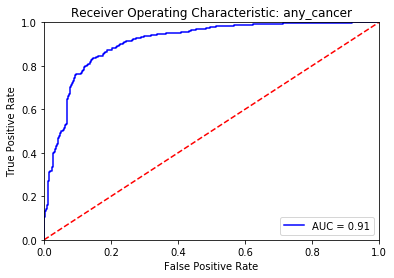

Average precision score: 0.92


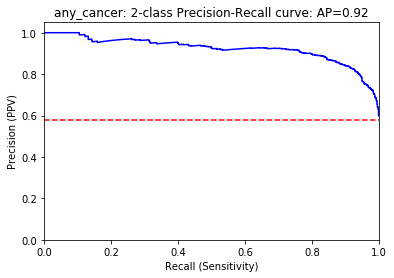

Best F1 for any_cancer:
0.8730583824317086
Threshold for best F1 in validation:
0.3557332
Threshold for best F1 in cross-validation:
0.43753779768575995
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[513 138]
 [105 789]]


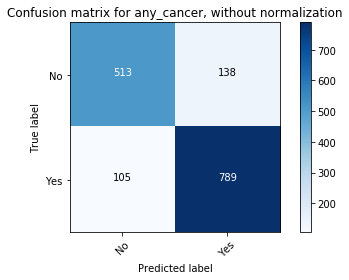

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.83      0.79      0.81       651
         Yes       0.85      0.88      0.87       894

   micro avg       0.84      0.84      0.84      1545
   macro avg       0.84      0.84      0.84      1545
weighted avg       0.84      0.84      0.84      1545

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[529 122]
 [119 775]]


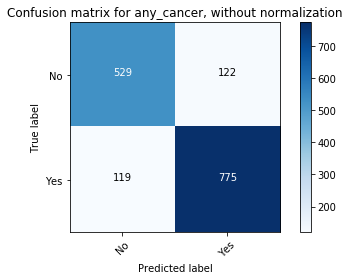

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.82      0.81      0.81       651
         Yes       0.86      0.87      0.87       894

   micro avg       0.84      0.84      0.84      1545
   macro avg       0.84      0.84      0.84      1545
weighted avg       0.84      0.84      0.84      1545



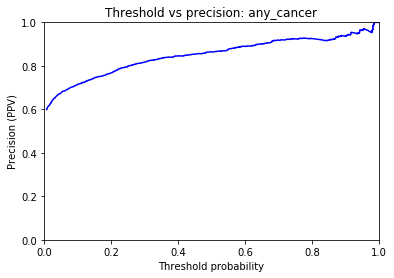

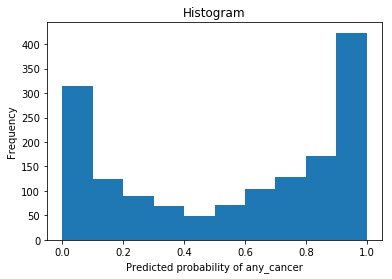

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.



In [15]:
train_generic_augmented(target='any_cancer', train_tokenizer=False, train_model=True)

Training data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11182 entries, 0 to 17957
Data columns (total 26 columns):
Unnamed: 0           11182 non-null int64
patient_id             11182 non-null int64
ehr_scan_date        11182 non-null object
PROC_DESCR           11182 non-null object
NARR_TXT             11182 non-null object
IMPRESS_TXT          11182 non-null object
os_date              11046 non-null object
died                 11182 non-null object
scan_to_os_date      11046 non-null float64
survived_6_months    11182 non-null int64
scan_type            11182 non-null float64
auto_type            11182 non-null float64
any_cancer           11182 non-null int64
redcap_resp_prog     6959 non-null float64
adrenal              11182 non-null int64
bone                 11182 non-null int64
brain                11182 non-null int64
liver                11182 non-null int64
lung                 11182 non-null int64
nodes                11182 non-null int64
peritoneum      

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 1), (None, 1 7164052     input_7[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 1), (None, 1 7164052     input_7[0][0]                    
__________________________________________________________________________________________________
model_3 (Model)                 [(None, 1), (None, 1 7164052     input_7[0][0]                    
__________________________________________________________________________________________________
model_4 (M

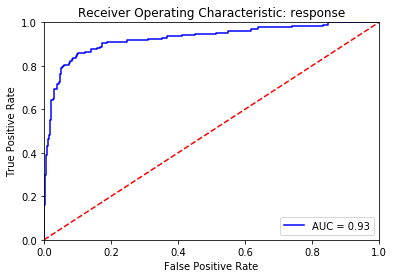

Average precision score: 0.75


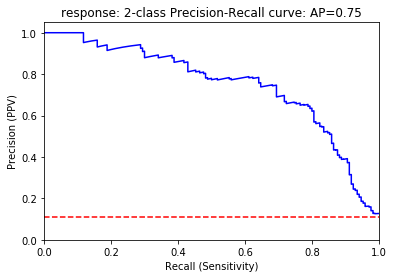

Best F1 for response:
0.7195121951219512
Threshold for best F1 in validation:
0.39449003
Threshold for best F1 in cross-validation:
0.3510607352965096
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1325   50]
 [  52  118]]


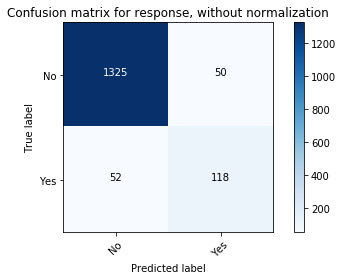

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.96      0.96      0.96      1375
         Yes       0.70      0.69      0.70       170

   micro avg       0.93      0.93      0.93      1545
   macro avg       0.83      0.83      0.83      1545
weighted avg       0.93      0.93      0.93      1545

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1346   29]
 [  66  104]]


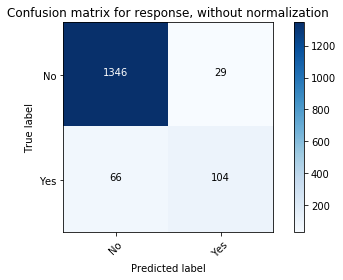

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.95      0.98      0.97      1375
         Yes       0.78      0.61      0.69       170

   micro avg       0.94      0.94      0.94      1545
   macro avg       0.87      0.80      0.83      1545
weighted avg       0.93      0.94      0.94      1545



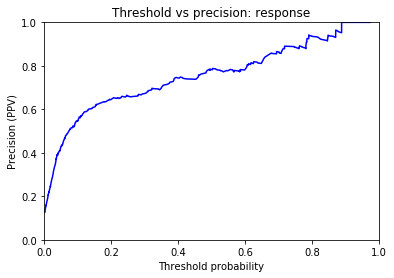

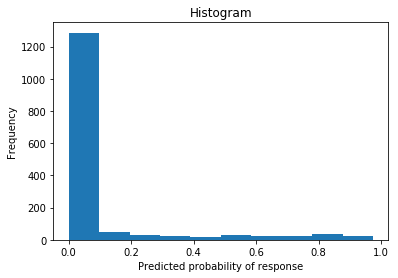

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.



In [16]:
train_generic_augmented(target='response', train_tokenizer=False, train_model=True)




Training data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11182 entries, 0 to 17957
Data columns (total 26 columns):
Unnamed: 0           11182 non-null int64
patient_id             11182 non-null int64
ehr_scan_date        11182 non-null object
PROC_DESCR           11182 non-null object
NARR_TXT             11182 non-null object
IMPRESS_TXT          11182 non-null object
os_date              11046 non-null object
died                 11182 non-null object
scan_to_os_date      11046 non-null float64
survived_6_months    11182 non-null int64
scan_type            11182 non-null float64
auto_type            11182 non-null float64
any_cancer           11182 non-null int64
redcap_resp_prog     6959 non-null float64
adrenal              11182 non-null int64
bone                 11182 non-null int64
brain                11182 non-null int64
liver                11182 non-null int64
lung                 11182 non-null int64
nodes                11182 non-null int64
peritoneum      

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
model_6 (Model)                 [(None, 1), (None, 1 7164052     input_13[0][0]                   
__________________________________________________________________________________________________
model_7 (Model)                 [(None, 1), (None, 1 7164052     input_13[0][0]                   
__________________________________________________________________________________________________
model_8 (Model)                 [(None, 1), (None, 1 7164052     input_13[0][0]                   
__________________________________________________________________________________________________
model_9 (M

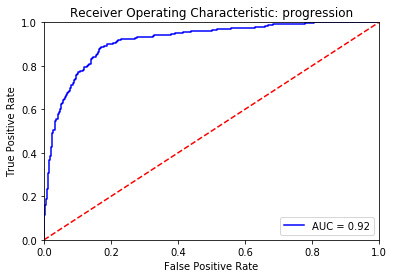

Average precision score: 0.78


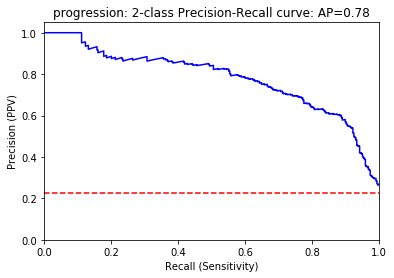

Best F1 for progression:
0.7265306122448979
Threshold for best F1 in validation:
0.4475796
Threshold for best F1 in cross-validation:
0.37709115330001997
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1051  146]
 [  72  276]]


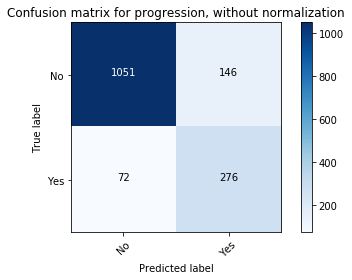

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.94      0.88      0.91      1197
         Yes       0.65      0.79      0.72       348

   micro avg       0.86      0.86      0.86      1545
   macro avg       0.79      0.84      0.81      1545
weighted avg       0.87      0.86      0.86      1545

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1094  103]
 [ 100  248]]


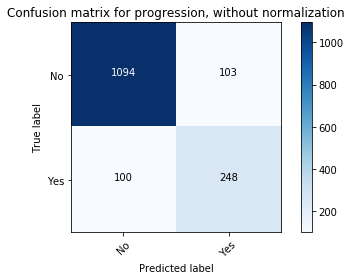

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.92      0.91      0.92      1197
         Yes       0.71      0.71      0.71       348

   micro avg       0.87      0.87      0.87      1545
   macro avg       0.81      0.81      0.81      1545
weighted avg       0.87      0.87      0.87      1545



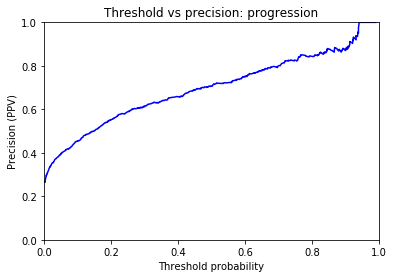

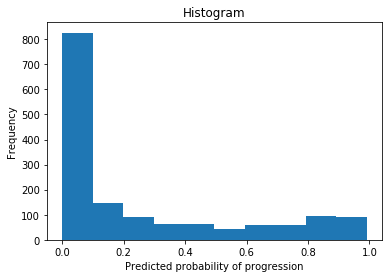

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.



In [17]:
train_generic_augmented(target='progression', train_tokenizer=False, train_model=True)

Training data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11182 entries, 0 to 17957
Data columns (total 26 columns):
Unnamed: 0           11182 non-null int64
patient_id             11182 non-null int64
ehr_scan_date        11182 non-null object
PROC_DESCR           11182 non-null object
NARR_TXT             11182 non-null object
IMPRESS_TXT          11182 non-null object
os_date              11046 non-null object
died                 11182 non-null object
scan_to_os_date      11046 non-null float64
survived_6_months    11182 non-null int64
scan_type            11182 non-null float64
auto_type            11182 non-null float64
any_cancer           11182 non-null int64
redcap_resp_prog     6959 non-null float64
adrenal              11182 non-null int64
bone                 11182 non-null int64
brain                11182 non-null int64
liver                11182 non-null int64
lung                 11182 non-null int64
nodes                11182 non-null int64
peritoneum      

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
model_11 (Model)                [(None, 1), (None, 1 7164052     input_19[0][0]                   
__________________________________________________________________________________________________
model_12 (Model)                [(None, 1), (None, 1 7164052     input_19[0][0]                   
__________________________________________________________________________________________________
model_13 (Model)                [(None, 1), (None, 1 7164052     input_19[0][0]                   
__________________________________________________________________________________________________
model_14 (

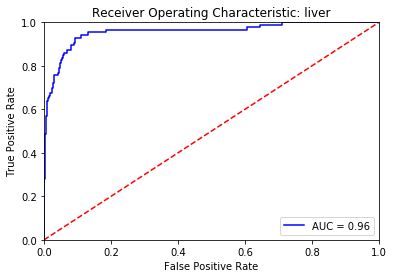

Average precision score: 0.76


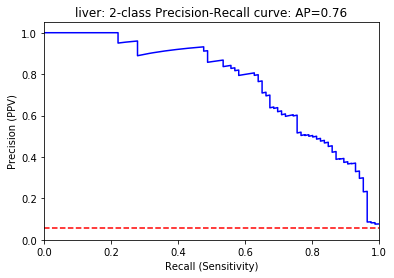

Best F1 for liver:
0.7096774193548387
Threshold for best F1 in validation:
0.37156215
Threshold for best F1 in cross-validation:
0.37446003336088174
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1445   14]
 [  32   54]]


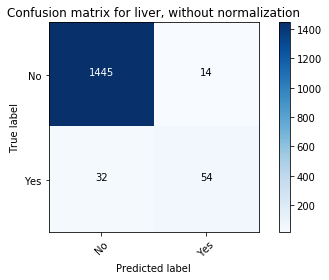

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.98      0.99      0.98      1459
         Yes       0.79      0.63      0.70        86

   micro avg       0.97      0.97      0.97      1545
   macro avg       0.89      0.81      0.84      1545
weighted avg       0.97      0.97      0.97      1545

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1452    7]
 [  40   46]]


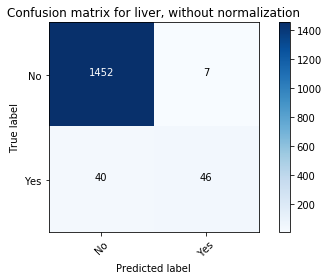

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.97      1.00      0.98      1459
         Yes       0.87      0.53      0.66        86

   micro avg       0.97      0.97      0.97      1545
   macro avg       0.92      0.77      0.82      1545
weighted avg       0.97      0.97      0.97      1545



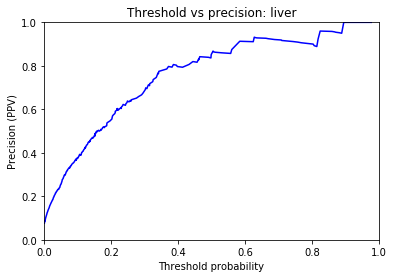

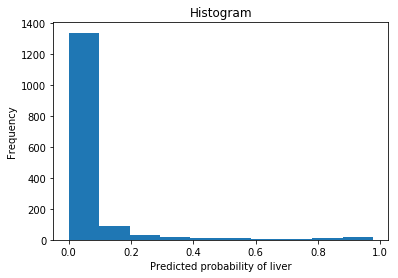

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.



In [18]:
train_generic_augmented(target='liver', train_tokenizer=False, train_model=True)

Training data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11182 entries, 0 to 17957
Data columns (total 26 columns):
Unnamed: 0           11182 non-null int64
patient_id             11182 non-null int64
ehr_scan_date        11182 non-null object
PROC_DESCR           11182 non-null object
NARR_TXT             11182 non-null object
IMPRESS_TXT          11182 non-null object
os_date              11046 non-null object
died                 11182 non-null object
scan_to_os_date      11046 non-null float64
survived_6_months    11182 non-null int64
scan_type            11182 non-null float64
auto_type            11182 non-null float64
any_cancer           11182 non-null int64
redcap_resp_prog     6959 non-null float64
adrenal              11182 non-null int64
bone                 11182 non-null int64
brain                11182 non-null int64
liver                11182 non-null int64
lung                 11182 non-null int64
nodes                11182 non-null int64
peritoneum      

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
model_16 (Model)                [(None, 1), (None, 1 7164052     input_25[0][0]                   
__________________________________________________________________________________________________
model_17 (Model)                [(None, 1), (None, 1 7164052     input_25[0][0]                   
__________________________________________________________________________________________________
model_18 (Model)                [(None, 1), (None, 1 7164052     input_25[0][0]                   
__________________________________________________________________________________________________
model_19 (

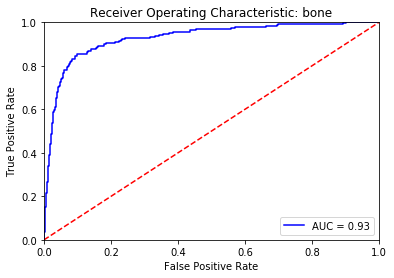

Average precision score: 0.74


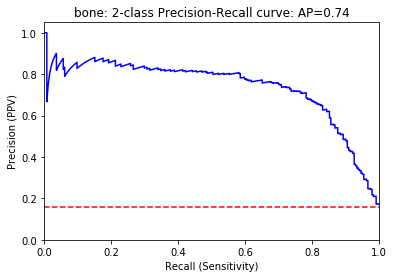

Best F1 for bone:
0.7446393762183237
Threshold for best F1 in validation:
0.27149153
Threshold for best F1 in cross-validation:
0.39705044282503316
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1242   59]
 [  71  173]]


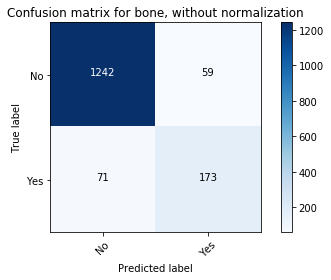

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.95      0.95      0.95      1301
         Yes       0.75      0.71      0.73       244

   micro avg       0.92      0.92      0.92      1545
   macro avg       0.85      0.83      0.84      1545
weighted avg       0.91      0.92      0.91      1545

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1254   47]
 [  89  155]]


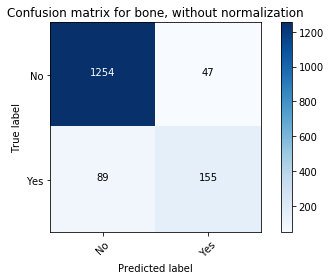

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.93      0.96      0.95      1301
         Yes       0.77      0.64      0.70       244

   micro avg       0.91      0.91      0.91      1545
   macro avg       0.85      0.80      0.82      1545
weighted avg       0.91      0.91      0.91      1545



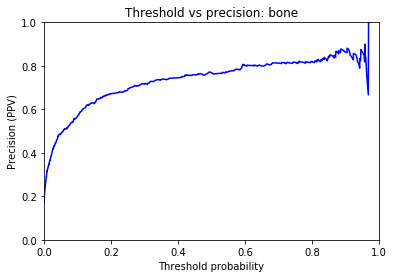

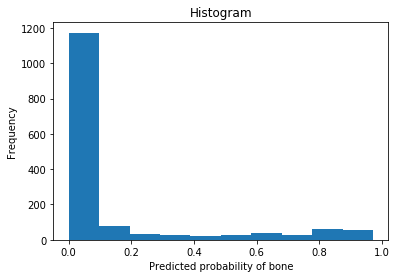

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.



In [19]:
train_generic_augmented(target='bone', train_tokenizer=False, train_model=True)

Training data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11182 entries, 0 to 17957
Data columns (total 26 columns):
Unnamed: 0           11182 non-null int64
patient_id             11182 non-null int64
ehr_scan_date        11182 non-null object
PROC_DESCR           11182 non-null object
NARR_TXT             11182 non-null object
IMPRESS_TXT          11182 non-null object
os_date              11046 non-null object
died                 11182 non-null object
scan_to_os_date      11046 non-null float64
survived_6_months    11182 non-null int64
scan_type            11182 non-null float64
auto_type            11182 non-null float64
any_cancer           11182 non-null int64
redcap_resp_prog     6959 non-null float64
adrenal              11182 non-null int64
bone                 11182 non-null int64
brain                11182 non-null int64
liver                11182 non-null int64
lung                 11182 non-null int64
nodes                11182 non-null int64
peritoneum      

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
model_21 (Model)                [(None, 1), (None, 1 7164052     input_31[0][0]                   
__________________________________________________________________________________________________
model_22 (Model)                [(None, 1), (None, 1 7164052     input_31[0][0]                   
__________________________________________________________________________________________________
model_23 (Model)                [(None, 1), (None, 1 7164052     input_31[0][0]                   
__________________________________________________________________________________________________
model_24 (

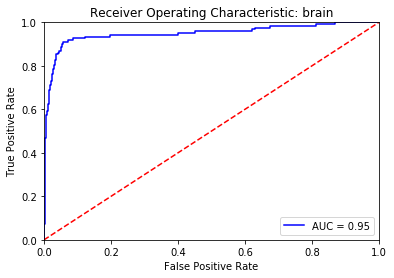

Average precision score: 0.79


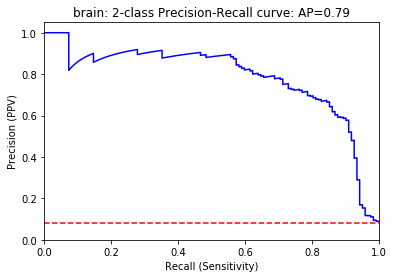

Best F1 for brain:
0.7500000000000001
Threshold for best F1 in validation:
0.4596214
Threshold for best F1 in cross-validation:
0.4088235999618745
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1376   47]
 [  23   99]]


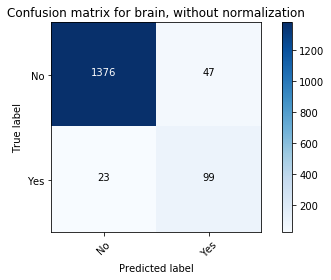

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.98      0.97      0.98      1423
         Yes       0.68      0.81      0.74       122

   micro avg       0.95      0.95      0.95      1545
   macro avg       0.83      0.89      0.86      1545
weighted avg       0.96      0.95      0.96      1545

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1389   34]
 [  32   90]]


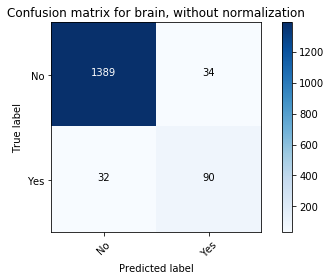

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.98      0.98      0.98      1423
         Yes       0.73      0.74      0.73       122

   micro avg       0.96      0.96      0.96      1545
   macro avg       0.85      0.86      0.85      1545
weighted avg       0.96      0.96      0.96      1545



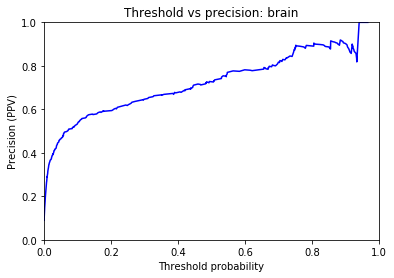

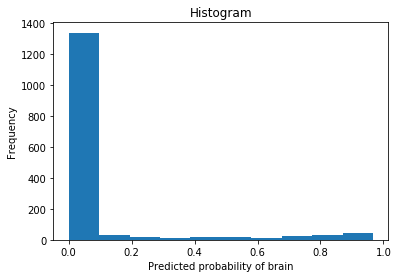

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.



In [20]:
train_generic_augmented(target='brain', train_tokenizer=False, train_model=True)

Training data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11182 entries, 0 to 17957
Data columns (total 26 columns):
Unnamed: 0           11182 non-null int64
patient_id             11182 non-null int64
ehr_scan_date        11182 non-null object
PROC_DESCR           11182 non-null object
NARR_TXT             11182 non-null object
IMPRESS_TXT          11182 non-null object
os_date              11046 non-null object
died                 11182 non-null object
scan_to_os_date      11046 non-null float64
survived_6_months    11182 non-null int64
scan_type            11182 non-null float64
auto_type            11182 non-null float64
any_cancer           11182 non-null int64
redcap_resp_prog     6959 non-null float64
adrenal              11182 non-null int64
bone                 11182 non-null int64
brain                11182 non-null int64
liver                11182 non-null int64
lung                 11182 non-null int64
nodes                11182 non-null int64
peritoneum      

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning:

invalid value encountered in true_divide



Loading data...
8856 train sequences
2326 test sequences
Pad sequences (samples x time)
x_train shape: (8856, 1000)
x_test shape: (2326, 1000)
Build model...
Train on 8856 samples, validate on 2326 samples
Epoch 1/2
8856/8856 [==============================] - 19s 2ms/step - loss: 0.7783 - main_output_loss: 0.3335 - anycancer_output_loss: 0.4448 - main_output_acc: 0.8576 - anycancer_output_acc: 0.7938 - val_loss: 0.7111 - val_main_output_loss: 0.3129 - val_anycancer_output_loss: 0.3981 - val_main_output_acc: 0.8594 - val_anycancer_output_acc: 0.8242
Epoch 2/2
8856/8856 [==============================] - 10s 1ms/step - loss: 0.4882 - main_output_loss: 0.2372 - anycancer_output_loss: 0.2510 - main_output_acc: 0.8882 - anycancer_output_acc: 0.9002 - val_loss: 0.8587 - val_main_output_loss: 0.3706 - val_anycancer_output_loss: 0.4881 - val_main_output_acc: 0.8611 - val_anycancer_output_acc: 0.8040
______________________________________________________________________________________________

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
model_26 (Model)                [(None, 1), (None, 1 7164052     input_37[0][0]                   
__________________________________________________________________________________________________
model_27 (Model)                [(None, 1), (None, 1 7164052     input_37[0][0]                   
__________________________________________________________________________________________________
model_28 (Model)                [(None, 1), (None, 1 7164052     input_37[0][0]                   
__________________________________________________________________________________________________
model_29 (

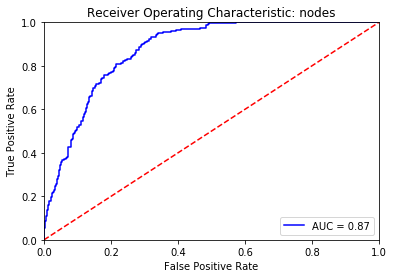

Average precision score: 0.49


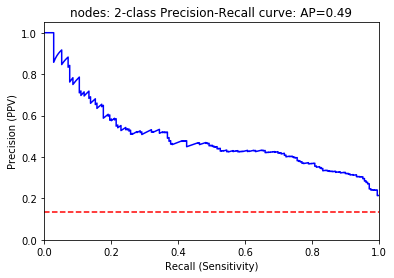

Best F1 for nodes:
0.5289855072463767
Threshold for best F1 in validation:
0.19558232
Threshold for best F1 in cross-validation:
0.27413597061457856
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1195  141]
 [  99  110]]


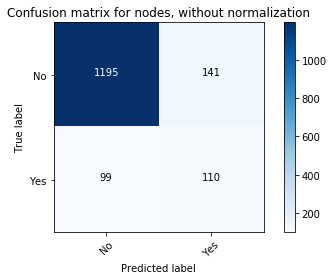

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.92      0.89      0.91      1336
         Yes       0.44      0.53      0.48       209

   micro avg       0.84      0.84      0.84      1545
   macro avg       0.68      0.71      0.69      1545
weighted avg       0.86      0.84      0.85      1545

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1284   52]
 [ 155   54]]


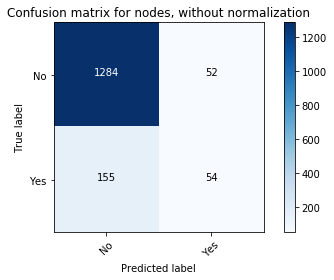

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.89      0.96      0.93      1336
         Yes       0.51      0.26      0.34       209

   micro avg       0.87      0.87      0.87      1545
   macro avg       0.70      0.61      0.63      1545
weighted avg       0.84      0.87      0.85      1545



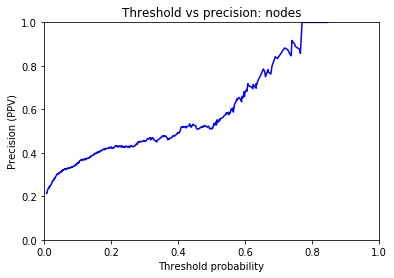

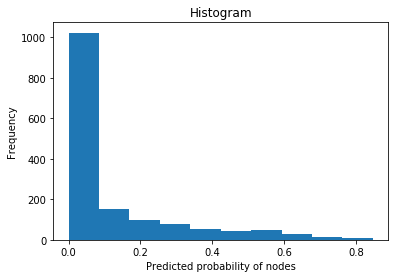

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.



In [21]:
train_generic_augmented(target='nodes', train_tokenizer=False, train_model=True)

Training data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11182 entries, 0 to 17957
Data columns (total 26 columns):
Unnamed: 0           11182 non-null int64
patient_id             11182 non-null int64
ehr_scan_date        11182 non-null object
PROC_DESCR           11182 non-null object
NARR_TXT             11182 non-null object
IMPRESS_TXT          11182 non-null object
os_date              11046 non-null object
died                 11182 non-null object
scan_to_os_date      11046 non-null float64
survived_6_months    11182 non-null int64
scan_type            11182 non-null float64
auto_type            11182 non-null float64
any_cancer           11182 non-null int64
redcap_resp_prog     6959 non-null float64
adrenal              11182 non-null int64
bone                 11182 non-null int64
brain                11182 non-null int64
liver                11182 non-null int64
lung                 11182 non-null int64
nodes                11182 non-null int64
peritoneum      

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 1000)         0                                            
__________________________________________________________________________________________________
model_31 (Model)                [(None, 1), (None, 1 7164052     input_43[0][0]                   
__________________________________________________________________________________________________
model_32 (Model)                [(None, 1), (None, 1 7164052     input_43[0][0]                   
__________________________________________________________________________________________________
model_33 (Model)                [(None, 1), (None, 1 7164052     input_43[0][0]                   
__________________________________________________________________________________________________
model_34 (

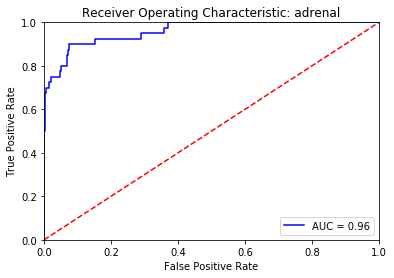

Average precision score: 0.69


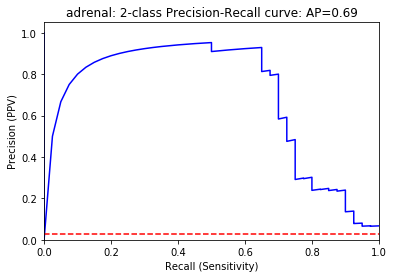

Best F1 for adrenal:
0.7647058823529412
Threshold for best F1 in validation:
0.8578845
Threshold for best F1 in cross-validation:
0.3495096286611511
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[1503    2]
 [  15   25]]


/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/site-packages/ipykernel_launcher.py:186: RuntimeWarning:

invalid value encountered in true_divide



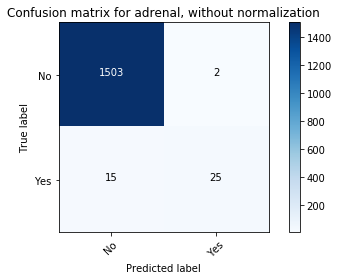

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.99      1.00      0.99      1505
         Yes       0.93      0.62      0.75        40

   micro avg       0.99      0.99      0.99      1545
   macro avg       0.96      0.81      0.87      1545
weighted avg       0.99      0.99      0.99      1545

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[1503    2]
 [  20   20]]


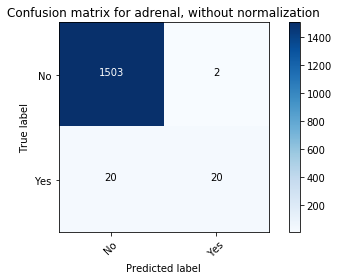

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.99      1.00      0.99      1505
         Yes       0.91      0.50      0.65        40

   micro avg       0.99      0.99      0.99      1545
   macro avg       0.95      0.75      0.82      1545
weighted avg       0.98      0.99      0.98      1545



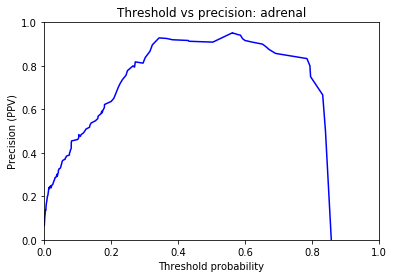

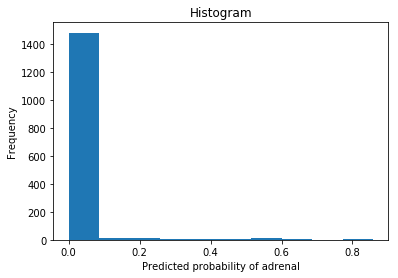

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.

/home/kenneth_kehl/anaconda3/envs/imaging_reps/lib/python3.6/re.py:212: FutureWarning:

split() requires a non-empty pattern match.



In [22]:
train_generic_augmented(target='adrenal', train_tokenizer=False, train_model=True)